# **6. OUTLIER DETECTION**

***Outlier Detection*** is the process of detecting outliers (*i.e.,* data points that differs significantly from the other observations) from a given set of data.

Outlier Detection Methods:
- STATISTICS-BASED
    - Hypothesis Testing
        - Grubbs test
    - Fitting distributions
        - Z-Score
        - MAD (Median absolute deviation)
        - IQR (Interquartile range)
        - Box Plots, Scatter Plots, Histograms
        - KDE (Kernel Density Estimation)
- DISTANCE-BASED
    - LOF (Local Outlier Factor)
- MODEL-BASED
    - k-Nearest Neighbors
    - Clustering (DBSCAN)


Import libraries:

In [1]:
!git clone https://github.com/camillasancricca/DATADIQ.git

Cloning into 'DATADIQ'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 238 (delta 44), reused 1 (delta 1), pack-reused 139 (from 1)
Receiving objects: 100% (238/238), 11.34 MiB | 3.58 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [2]:
!pip install outlier-utils

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import quantile

import sklearn
from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import load_iris
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

from outliers import smirnov_grubbs as grubbs
import matplotlib.pyplot as plt

from DATADIQ import scripts_for_E5 as s

**1. STATISTICS-BASED**

Hypothesis Testing **Grubbs Test**

- Steps:
      1. Define:
            1.1 Null (no outliers) and Alternative (1 outlier) hypothesis
            1.2 The appropriate test and the relevant test statistic T
            1.3 Significance level alpha (below this threshold reject the null hyp.)
            1.4 Critical region (values) in which null hyp. is rejected
      2. Compute from the current data the observed value of t
      3. Reject the null hyp. if t is under the critical region

In [5]:
#Create data
data = np.array([20, 21, 26, 24, 29,
				22, 21, 50, 28, 27, 5])

#Perform two-side Grubbs' test
grubbs.test(data, alpha=0.2)

array([20, 21, 26, 24, 29, 22, 21, 28, 27])

In [8]:
print("Data after performing min one-side grubb's test: ")

#Perform min Grubbs' test
grubbs.min_test(data, alpha=0.2)

Data after performing min one-side grubb's test: 


array([20, 21, 26, 24, 29, 22, 21, 50, 28, 27])

In [7]:
print("Data after performing max one-side grubb's test: ")

#Perform max Grubbs' test
grubbs.max_test(data, alpha=0.05)  #(this tecnique not so common, not suggested)

Data after performing max one-side grubb's test: 


array([20, 21, 26, 24, 29, 22, 21, 28, 27,  5])

Fitting distributions **Z-Score**

- Data values that have a Z-Score > threshold (e.g. 2) are declared to be outliers.
      Z-Score = abs(observation - mean)/std

In [10]:
def ZS(data, threshold):
    mean = np.mean(data)
    sd = np.std(data) # calculate standard deviation
    outliers = [] # create empty list to store outliers
    for i in data: # detect outliers
        z = (i - mean) / sd  # calculate z-score
        if abs(z) > threshold:  # identify outliers
            outliers.append(i)  # add to the empty list

    # print outliers
    print("The detected outliers are: ", str(outliers))

In [9]:
DATA = np.array([20, 21, 26, 24, 29,
				22, 21, 50, 28, 27, 5])

In [11]:
ZS(DATA, 2)

The detected outliers are:  [np.int64(50)]


In [12]:
ZS(DATA, 1)

The detected outliers are:  [np.int64(50), np.int64(5)]


Fitting distributions **Standard Deviation**

- Data values that have a score > V1 or < V2 are declared to be outliers.
      V1 = mean + threshold * std
      V2 = mean - threshold * std


In [13]:
def STD(data, th):
    mean = data.mean()
    std = data.std()
    V1 = mean + th * std
    V2 = mean - th * std
    outliers = []
    outliers_ind = []
    for d in data:
        if (d > V1) | (d < V2):
            outliers.append(d)

    return outliers

In [14]:
STD(DATA, 2)

[np.int64(50)]

In [15]:
STD(DATA, 1)

[np.int64(50), np.int64(5)]

Fitting distributions **Percentage**

- Data values outside the fixed percentiles are declared to be outliers.


In [16]:
def PERC(data):
    V1 = np.percentile(data, 99)
    V2 = np.percentile(data , 1)
    outliers = []
    for d in data:
        if (d > V1) | (d < V2):
            outliers.append(d)

    return outliers

In [17]:
PERC(DATA)

[np.int64(50), np.int64(5)]

Fitting distributions **Mean Absolute Deviation (MAD)**

- Robust Zscore as a function of median and median. Defined as:
      Z-Score = |x – median(x)| / mad(x)

In [18]:
def ZSB(data, threshold):
    # Robust Zscore as a function of median and median
    # median absolute deviation (MAD) defined as
    # z-score = |x – median(x)| / mad(x)
    median = np.median(data)
    median_absolute_deviation = np.median(np.abs(data - median))
    modified_z_scores = (data - median) / median_absolute_deviation
    outliers = data[np.abs(modified_z_scores) > threshold]
    # print outliers
    print("The detected outliers are: ", str(outliers))

In [19]:
ZSB(DATA, 2)

The detected outliers are:  [50  5]


Fitting distributions **Interquartile Range (IQR)**

- The interquartile range is the middle half of the data that lies between the upper and lower quartiles.
In other words, the interquartile range includes the 50% of data points that are above Q1 and below Q3.
    - The lowest quartile (Q1) covers the smallest quarter of values in your dataset.
    - The upper quartile (Q3) comprises the highest quarter of values.
- Data values that are outside the interval
      Q1-(1.5*IQR) / Q3+(1.5*IQR)
    are declared to be **outliers**.

In [21]:
def IQR(data):
    sorted(data)
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    outliers = data[((data < lower_range) | (data > upper_range))]
    # print outliers
    print("The detected outliers are: ", str(outliers))

IQR(DATA)

The detected outliers are:  [50  5]


In [22]:
CAL = fetch_california_housing()

In [23]:
#Create the dataframe
column_name = CAL.feature_names
CAL = pd.DataFrame(CAL.data)
CAL.columns = column_name
CAL

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [24]:
ZSB(np.array(CAL['Population']),10) #(to decide real outlier and threshold first plot the distribution)

The detected outliers are:  [ 7427.  5781.  5613.  8117.  8012.  6075.  7205. 12203.  5826.  8768.
  6693.  7517.  5613.  7653.  7266.  7009.  5696.  6241.  5666.  7679.
  6161.  9135.  7096.  7307.  7282.  7450.  5899.  7221.  7443.  5840.
  6846.  6270.  7665.  7249.  7775.  8686. 15507.  9427.  8380.  9671.
 15037.  6652.  8997.  5587.  8907.  7732. 10988.  7228.  6666.  6626.
  8551.  7429.  7211.  7180.  6664.  6897.  7431.  6214.  9873. 12873.
  6163. 10493.  6291.  7694.  5731.  5839. 11973.  5871.  8152.  8721.
 10475.  7270.  7030.  9842.  7087.  7158.  8733.  9936.  6902.  5600.
  6109.  5917.  6012. 11272.  7249. 12153.  5982. 28566.  6071. 16122.
  6223.  6083.  5756.  6799.  7111.  8361.  7540.  5913.  5810.  7600.
  7305.  6295.  8222.  5964.  5650.  9851.  8805.  6763.  6780.  8437.
  5804.  5595.  7596.  6686.  9509.  9623.  9360.  7235.  7139.  9419.
  7132.  8824. 13251.  5860.  6159.  6274.  5682. 11935.  5656.  7235.
  5692.  5634.  7919.  7463.  8652.  7608.  6068.

Fitting distributions **Box-Plots, Scatter Plots, Histograms**

<Axes: ylabel='Population'>

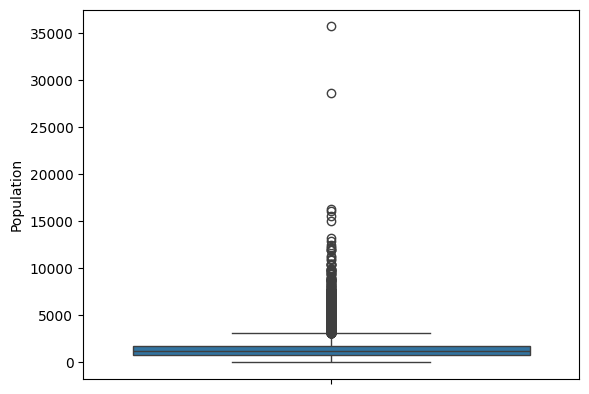

In [25]:
#Box Plot
sns.boxplot(CAL['Population'])

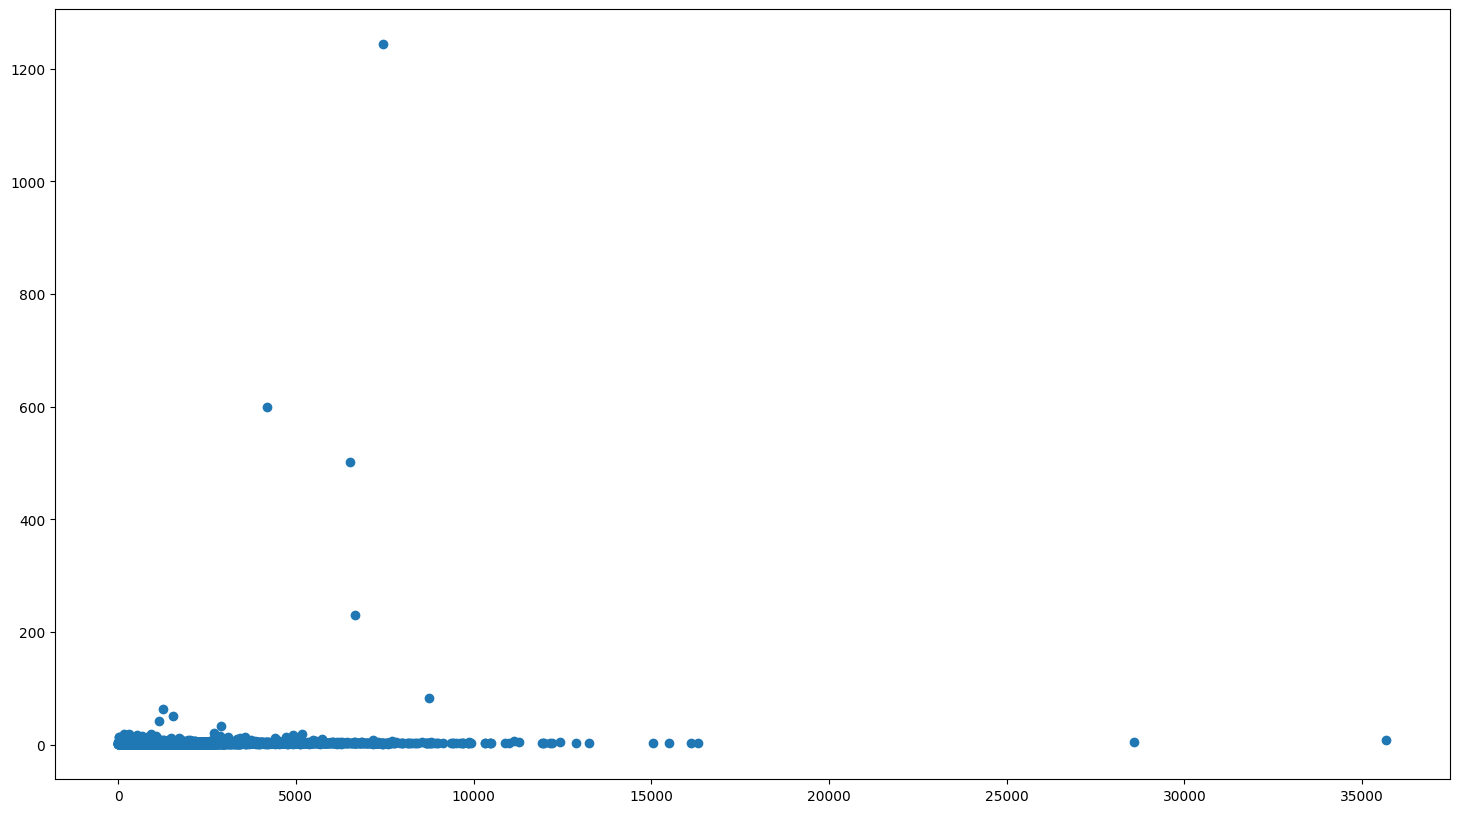

In [26]:
#Scatter Plot
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(CAL['Population'], CAL['AveOccup'])
plt.show()

<Axes: xlabel='Population'>

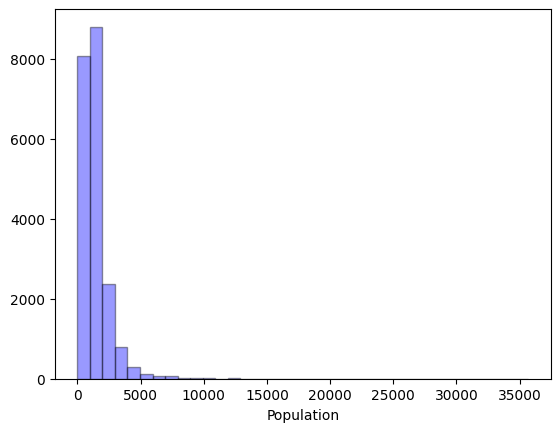

In [27]:
#Histogram
sns.distplot(CAL['Population'], hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

Fitting distributions **Kernel-Density Estimation (KDE)**

      KDE estimates the distribution probability of a random variable as a density function f(x).
      It’s related to the histogram of the distribution plus a data smoothing factor.
      To smoothen the distribution, different kernels can be used.
      The output is a smooth density estimate.

<Axes: ylabel='Density'>

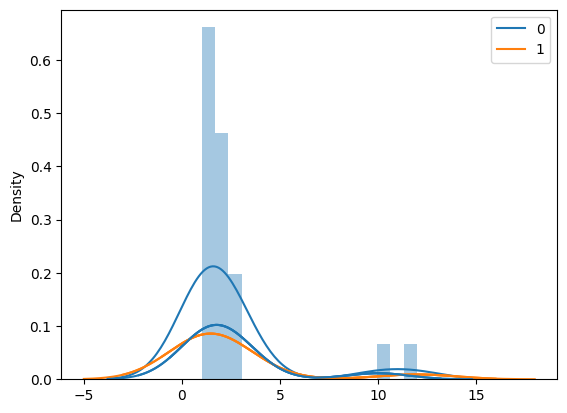

In [28]:
X = np.array([[2, 1], [2, 3], [2, 1], [1, 2], [1, 1], [2, 1], [3, 2], [10, 12], [1, 1], [3, 2], [1, 1]])
sns.distplot(X, hist=True, kde=True)
sns.kdeplot(X, cut=1)
sns.kdeplot(X, cut=2)
sns.kdeplot(X, cut=3)

In [29]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
scores = kde.score_samples(X)
threshold = quantile(scores, .02)

idx = np.where(scores <= threshold)
outliers = X[idx]
print("Outliers:", outliers)

**2. DISTANCE-BASED**

  **Local Outlier Factor (LOF)**

  - The LOF scores data points based on the density of their neighbouring data points. The score depends on how isolated the object is with respect to the surrounding k-neighborhood. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

    Given:
      - p, o objects
      - a positive integer k (minimum number of neighbours)
      - k-distance(o)

    Define:
      1. Reachability Distance (RD) = distance(p,o) if they are far,
      average distance among the closer points if they are close: max(k-distance(o), distance(p,o))

      2. Local Reachability Distance (LRD): more the average reachability distance, less density of points are present around a particular point.

      3. Local Outlier Factor: ~ 1 Similar density as neighbors, < 1 Higher density than neighbors (Inlier), > 1 Lower density than neighbors (**Outlier**)

In [31]:
def LOF_outlier_detection(X):
    data = X
    # requires no missing value
    # select top 10 outliers


    # fit the model for outlier detection (default)
    clf = LocalOutlierFactor(n_neighbors=4, contamination=0.1)

    clf.fit_predict(X)

    LOF_scores = clf.negative_outlier_factor_
    # Outliers tend to have a negative score far from -1

    #print(LOF_scores)

    outliers = X[LOF_scores < -1.9].index

    print("Outliers: ", data.iloc[outliers])
LOF_outlier_detection(CAL)


Outliers:          MedInc  HouseAge   AveRooms  AveBedrms  Population   AveOccup  \
154     8.1564      52.0   7.702632   1.057895      1021.0   2.686842   
270     3.8750      33.0   3.021277   0.659574       575.0  12.234043   
511    13.4990      42.0   8.928358   1.000000      1018.0   3.038806   
514    12.3804      52.0   9.122715   1.033943      1192.0   3.112272   
1067    3.4191      52.0   4.530612   0.816327      1107.0  11.295918   
...        ...       ...        ...        ...         ...        ...   
19435   0.5360      16.0   2.111111   2.111111       166.0  18.444444   
19524   0.9573      19.0   2.951220   1.000000       658.0  16.048780   
19536   4.2500       1.0  20.125000   2.928571       402.0   3.589286   
20352   4.0208       8.0   2.500000   0.625000       309.0  19.312500   
20544   2.0650      23.0   4.803493   1.013646      6330.0   3.455240   

       Latitude  Longitude  
154       37.81    -122.22  
270       37.78    -122.18  
511       37.82    -122.2

**3. MODEL-BASED**

  Outlier Detection using **k-Nearest Neighbors (KNN)** and **Isolation Forest** algorithms

In [32]:
IRIS = load_iris()

In [33]:
#Create the dataframe
column_name = IRIS.feature_names
IRIS = pd.DataFrame(IRIS.data)
IRIS.columns = column_name


In [34]:
X = IRIS.values


In [35]:
#Instantiate model (KNN)
KNN = NearestNeighbors(n_neighbors=3)

In [37]:
#Fit model
KNN.fit(X)

NearestNeighbors(n_neighbors=3)

In [38]:
#Distances and indexes of k-neaighbors from model outputs
distances, indexes = KNN.kneighbors(X)

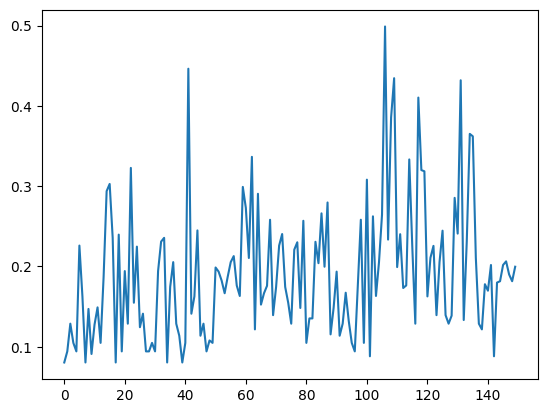

In [39]:
#Plot mean of k-distances of each observation
plt.plot(distances.mean(axis=1))

In [41]:
#Visually determine cutoff values > 0.25
out_index = np.where(distances.mean(axis=1) > 0.25)

In [42]:
#Filter outlier values
OUTLIERS_VALUES = IRIS.iloc[out_index]
OUTLIERS_VALUES

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
14,5.8,4.0,1.2,0.2
15,5.7,4.4,1.5,0.4
22,4.6,3.6,1.0,0.2
41,4.5,2.3,1.3,0.3
59,5.2,2.7,3.9,1.4
60,5.0,2.0,3.5,1.0
62,6.0,2.2,4.0,1.0
64,5.6,2.9,3.6,1.3
68,6.2,2.2,4.5,1.5
79,5.7,2.6,3.5,1.0


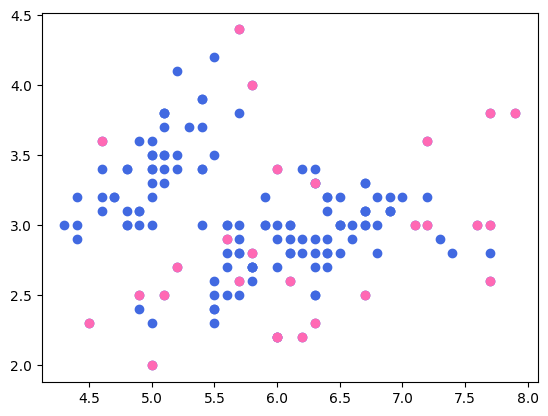

In [43]:
#Plot data
plt.scatter(IRIS["sepal length (cm)"], IRIS["sepal width (cm)"], color = "royalblue")
plt.scatter(OUTLIERS_VALUES["sepal length (cm)"], OUTLIERS_VALUES["sepal width (cm)"], color = "hotpink")
plt.show()

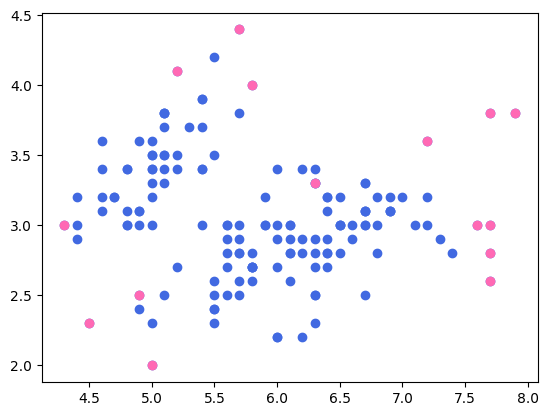

In [44]:
### Isolation Forest

model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0)
model.fit(X)
prova = pd.DataFrame()
prova['scores'] = model.decision_function(X)
prova['anomaly'] = model.predict(X)
anomaly = prova.loc[prova['anomaly'] == -1]
OUTLIER_INDEX = list(anomaly.index)

#Filter outlier values
OUTLIERS_VALUES = IRIS.iloc[OUTLIER_INDEX]
OUTLIERS_VALUES

#Plot data
plt.scatter(IRIS["sepal length (cm)"], IRIS["sepal width (cm)"], color = "royalblue")
plt.scatter(OUTLIERS_VALUES["sepal length (cm)"], OUTLIERS_VALUES["sepal width (cm)"], color = "hotpink")
plt.show()

  Outlier Detection using **Clustering (DBSCAN)** Algorithm

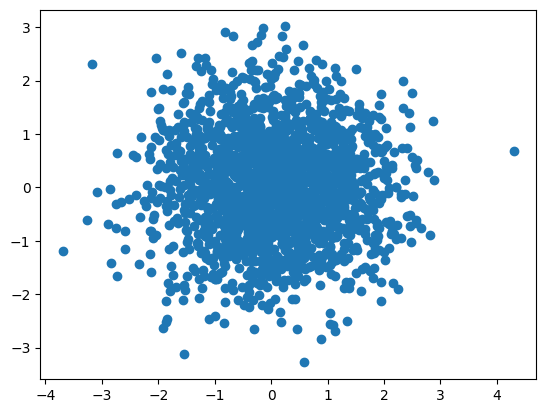

In [45]:
#Create a set of 2000 random data like [x,y]
random_data = np.random.randn(2000,2)
plt.scatter(random_data[:,0], random_data[:,1], cmap='Paired')

In [46]:
#Inizialize and Fit DBSCAN Clustering Algorithm
dbscan = DBSCAN(min_samples = 2, eps = 0.1)
clusters = dbscan.fit_predict(random_data)
clusters

array([-1,  0,  0, ..., -1,  0,  0])

In [47]:
#Founded outliers belong to the cluster -1
clusters[clusters > -1] = 0
list(clusters).count(-1)

211

Text(0.5, 1.0, 'DBSCAN')

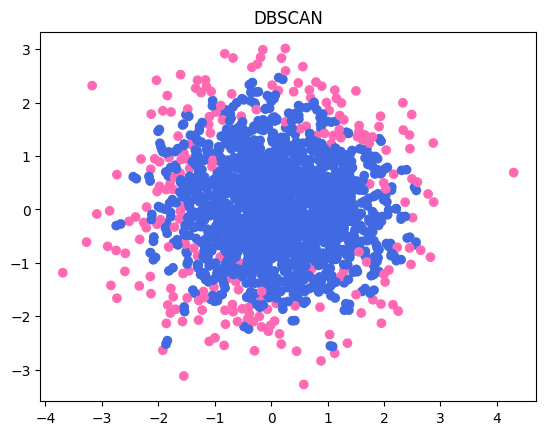

In [48]:
#Plot data

#Colormap
colormap = np.array(['royalblue', 'hotpink'])

plt.scatter(random_data[:,0], random_data[:,1],c=colormap[clusters], cmap='Paired')
plt.title("DBSCAN")

**Summary**

*Grubbs test:*

- grubbs.min_test()
- grubbs.max_test()
- grubbs.min/max_test_indices()
- grubbs.min/max_test_outliers()

*Box Plots, Scatter Plots, Histograms:*

- sns.boxplot()
- plt.scatter()
- sns.distplot()

*Algorithms:*

- KernelDensity()
- LocalOutlierFactor()
- NearestNeighbors()
- IsolationForest()
- DBSCAN()